In [ ]:
import os
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

# === (Optional) Step 1: Extract Dataset ===
# Skip this if you've already extracted the ZIP
# zip_path = "PartB_DFU_Dataset_Infection.zip"
# extract_to = "dataset"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)
# print("✅ Extraction completed!")

# === Step 2: Set Dataset Path ===
data_root = "dataset/PartB_DFU_Dataset/Infection"

# === Step 3: Transforms ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Step 4: Custom Dataset ===
class DFUDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.samples = []
        for label, folder in enumerate(['Aug-Negative', 'Aug-Positive']):
            folder_path = os.path.join(root, folder)
            for img_path in glob.glob(f"{folder_path}/*.jpg"):
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = DFUDataset(data_root, transform)

# === Step 5: Dataset Split ===
from math import floor

total_len = len(dataset)
print(f"📦 Total images: {total_len}")

train_len = max(1, floor(0.7 * total_len))
val_len = max(1, floor(0.15 * total_len))
test_len = total_len - train_len - val_len

# Adjustment if needed
if train_len + val_len + test_len > total_len:
    test_len = total_len - train_len - val_len
elif train_len + val_len + test_len < total_len:
    train_len += total_len - (train_len + val_len + test_len)

print(f"🔀 Splits → Train: {train_len}, Val: {val_len}, Test: {test_len}")

train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len])

# Final check
if len(train_data) == 0 or len(val_data) == 0 or len(test_data) == 0:
    raise ValueError("❌ One of the dataset splits is empty!")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# === Step 6: GAN Models ===
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        base_model = models.densenet121(pretrained=True)
        base_model.classifier = nn.Identity()
        self.features = base_model
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        features = self.features(img)
        return self.fc(features)

# === Step 7: Train GAN ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

epochs = 20
for epoch in range(epochs):
    for imgs, _ in train_loader:
        real = imgs.to(device)
        batch_size = real.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"🌀 Epoch {epoch+1}/{epochs} → D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# === Step 8: Transfer Learning Classifier ===
resnet = models.resnet152(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)

clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

def train_classifier(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = clf_criterion(outputs, labels)

            clf_optimizer.zero_grad()
            loss.backward()
            clf_optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        print(f"📘 Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/len(loader.dataset):.4f}")

train_classifier(resnet, train_loader, epochs=10)

# === Step 9: Evaluation ===
resnet.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = resnet(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# === Step 10: Metrics ===
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Infected', 'Non-Infected']))

accuracy = accuracy_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ AUROC: {auroc:.4f}")

# === Step 11: ROC Curve ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


📦 Total images: 5890
🔀 Splits → Train: 4123, Val: 883, Test: 884


C:\Users\praja\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\praja\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\praja/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:15<00:00, 2.08MB/s]


🌀 Epoch 1/20 → D Loss: 0.1665 | G Loss: 2.0037


In [1]:
import zipfile

zip_path = "PartB_DFU_Dataset_Infection.zip"  # Replace with the correct filename
extract_to = "dataset"  # Folder where files will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")


BadZipFile: File is not a zip file

In [8]:
dataset/PartB_DFU_Dataset_Infection/aug_neg/
dataset/PartB_DFU_Dataset_Infection/aug_pos/


SyntaxError: invalid syntax (838611781.py, line 1)

In [9]:
import os
import glob

# Path to the folder
path = "dataset/PartB_DFU_Dataset_Infection/aug_neg/"

# Check how many .jpg images are there
images = glob.glob(os.path.join(path, "*.jpg"))
print(f"Found {len(images)} images in {path}")


Found 0 images in dataset/PartB_DFU_Dataset_Infection/aug_neg/


In [10]:
for subfolder in ['aug_neg', 'aug_pos']:
    path = os.path.join("dataset/PartB_DFU_Dataset_Infection", subfolder)
    images = glob.glob(os.path.join(path, "*.jpg"))
    print(f"{subfolder}: {len(images)} images")


aug_neg: 0 images
aug_pos: 0 images


In [11]:
import os
import glob

# Root dataset path
root_dir = "dataset/PartB_DFU_Dataset_Infection"

# Check all subfolders and print .jpg counts
def check_image_folders(root_dir, extension="*.jpg"):
    if not os.path.exists(root_dir):
        print(f"❌ Root directory '{root_dir}' not found.")
        return

    print(f"📂 Scanning: {root_dir}\n")

    total_files = 0
    for subdir, dirs, files in os.walk(root_dir):
        image_files = glob.glob(os.path.join(subdir, extension))
        count = len(image_files)
        total_files += count
        print(f"📁 {subdir} → {count} image(s)")
        if count == 0:
            print("⚠️  This folder is empty!")

    print(f"\n✅ Done. Total {extension} files found: {total_files}")

# Run the check
check_image_folders("dataset/PartB_DFU_Dataset_Infection")


❌ Root directory 'dataset/PartB_DFU_Dataset_Infection' not found.


In [12]:
import os

root = "dataset"

print(f"🔍 Searching under: {root}\n")
for dirpath, dirnames, filenames in os.walk(root):
    print(f"📁 {dirpath}")


🔍 Searching under: dataset

📁 dataset
📁 dataset\PartB_DFU_Dataset
📁 dataset\PartB_DFU_Dataset\Infection
📁 dataset\PartB_DFU_Dataset\Infection\Aug-Negative
📁 dataset\PartB_DFU_Dataset\Infection\Aug-Positive


In [4]:
import zipfile
import os

# Correct path to the ZIP file
zip_path = './PartB_DFU_Dataset_Infection.zip'

# Directory to extract to
extract_dir = './PartB_DFU_Dataset_Infection'

# Make sure the extraction directory exists
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extraction complete! Files are in: {extract_dir}")


Extraction complete! Files are in: ./PartB_DFU_Dataset_Infection


📦 Total images: 5890
🔀 Splits → Train: 4123, Val: 883, Test: 884


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100.0%


🌀 Epoch 1/20 → D Loss: 0.1481 | G Loss: 1.9788
🌀 Epoch 2/20 → D Loss: 0.0261 | G Loss: 3.6300
🌀 Epoch 3/20 → D Loss: 0.0092 | G Loss: 4.6912
🌀 Epoch 4/20 → D Loss: 0.0082 | G Loss: 5.3527
🌀 Epoch 5/20 → D Loss: 0.0036 | G Loss: 5.6633
🌀 Epoch 6/20 → D Loss: 0.0026 | G Loss: 6.1281
🌀 Epoch 7/20 → D Loss: 0.0019 | G Loss: 6.3298
🌀 Epoch 8/20 → D Loss: 0.0014 | G Loss: 6.5712
🌀 Epoch 9/20 → D Loss: 0.0014 | G Loss: 6.5137
🌀 Epoch 10/20 → D Loss: 0.0009 | G Loss: 7.0187
🌀 Epoch 11/20 → D Loss: 0.0009 | G Loss: 7.1421
🌀 Epoch 12/20 → D Loss: 0.0006 | G Loss: 7.4295
🌀 Epoch 13/20 → D Loss: 0.0006 | G Loss: 7.3872
🌀 Epoch 14/20 → D Loss: 0.0005 | G Loss: 7.6779
🌀 Epoch 15/20 → D Loss: 0.0004 | G Loss: 7.8159
🌀 Epoch 16/20 → D Loss: 0.0004 | G Loss: 7.9686
🌀 Epoch 17/20 → D Loss: 0.0007 | G Loss: 7.2252
🌀 Epoch 18/20 → D Loss: 0.0003 | G Loss: 8.2208
🌀 Epoch 19/20 → D Loss: 0.0002 | G Loss: 8.3753
🌀 Epoch 20/20 → D Loss: 0.0002 | G Loss: 8.4983


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100.0%


📘 Epoch 1 | Loss: 67.4153 | Acc: 0.7378
📘 Epoch 2 | Loss: 24.9206 | Acc: 0.9326
📘 Epoch 3 | Loss: 8.4481 | Acc: 0.9789
📘 Epoch 4 | Loss: 8.0966 | Acc: 0.9789
📘 Epoch 5 | Loss: 5.0701 | Acc: 0.9876
📘 Epoch 6 | Loss: 5.0334 | Acc: 0.9874
📘 Epoch 7 | Loss: 5.8332 | Acc: 0.9842
📘 Epoch 8 | Loss: 6.0901 | Acc: 0.9828
📘 Epoch 9 | Loss: 4.7310 | Acc: 0.9862
📘 Epoch 10 | Loss: 4.0204 | Acc: 0.9886

📊 Classification Report:
              precision    recall  f1-score   support

    Infected       0.92      0.85      0.88       450
Non-Infected       0.85      0.92      0.89       434

    accuracy                           0.88       884
   macro avg       0.89      0.88      0.88       884
weighted avg       0.89      0.88      0.88       884

✅ Accuracy: 0.8835
✅ AUROC: 0.9532


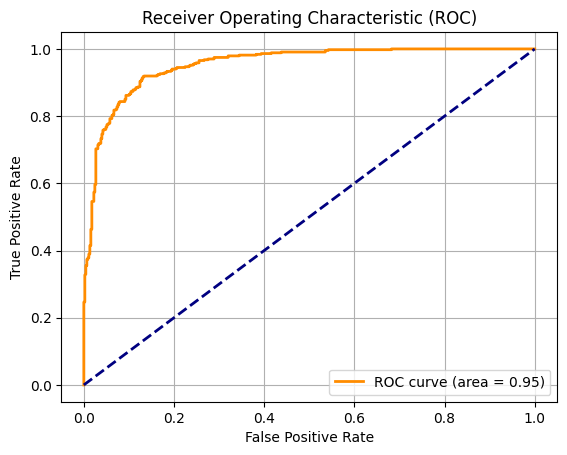

In [3]:
import os
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import DenseNet121_Weights, ResNet152_Weights

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

# === Set Correct Dataset Path ===
data_root = "./PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection"

# === Image Transformations ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Custom Dataset ===
class DFUDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.samples = []
        for label, folder in enumerate(['Aug-Negative', 'Aug-Positive']):
            folder_path = os.path.join(root, folder)
            for img_path in glob.glob(f"{folder_path}/*.jpg"):
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# === Load Dataset and Create Splits ===
dataset = DFUDataset(data_root, transform)
total_len = len(dataset)
print(f"📦 Total images: {total_len}")

train_len = max(1, int(0.7 * total_len))
val_len = max(1, int(0.15 * total_len))
test_len = total_len - train_len - val_len

# Adjust split if needed
if train_len + val_len + test_len < total_len:
    train_len += total_len - (train_len + val_len + test_len)

print(f"🔀 Splits → Train: {train_len}, Val: {val_len}, Test: {test_len}")

train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# === Generator Network ===
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# === Discriminator using DenseNet121 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        base_model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        base_model.classifier = nn.Identity()
        self.features = base_model
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        features = self.features(img)
        return self.fc(features)

# === GAN Training Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

epochs = 20
for epoch in range(epochs):
    for imgs, _ in train_loader:
        real = imgs.to(device)
        batch_size = real.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # === Train Generator ===
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # === Train Discriminator ===
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"🌀 Epoch {epoch+1}/{epochs} → D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# === Transfer Learning Classifier using ResNet152 ===
resnet = models.resnet152(weights=ResNet152_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)

clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

def train_classifier(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = clf_criterion(outputs, labels)

            clf_optimizer.zero_grad()
            loss.backward()
            clf_optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        print(f"📘 Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {correct/len(loader.dataset):.4f}")

train_classifier(resnet, train_loader, epochs=10)

# === Evaluation ===
resnet.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = resnet(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# === Metrics ===
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Infected', 'Non-Infected']))

accuracy = accuracy_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ AUROC: {auroc:.4f}")

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


🩺 Prediction: Infected
📊 Confidence: 0.9966


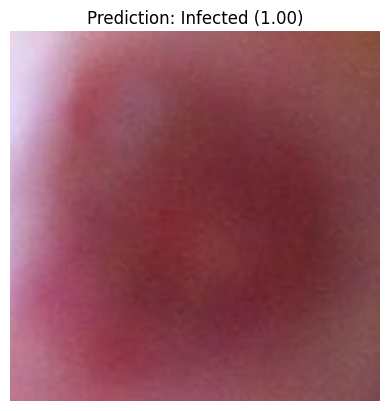

In [6]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# === Path to your test image ===
test_image_path = "PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection/Aug-Positive/001988_20.jpg"
test_image_path = "PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection/Aug-Negative/001992_10.jpg"

# === Transform (same as training) ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load image and preprocess ===
image = Image.open(test_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# === Predict with ResNet152 ===
resnet.eval()
with torch.no_grad():
    output = resnet(input_tensor)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# === Class Labels ===
class_names = ['Infected', 'Non-Infected']
confidence = probabilities[0][predicted_class].item()

# === Show result ===
print(f"🩺 Prediction: {class_names[predicted_class]}")
print(f"📊 Confidence: {confidence:.4f}")

# === Show image with label ===
plt.imshow(image)
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [6]:
!pip install torch torchvision
!pip install scikit-learn
!pip install matplotlib
!pip install pillow



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 186.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 331.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 164.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 322.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 242.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os

root_path = "./PartB_DFU_Dataset_Infection"  # Change this to your dataset root

print(f"🔍 Subfolders inside: {root_path}\n")
for dirpath, dirnames, filenames in os.walk(root_path):
    print(f"📁 {dirpath}")


🔍 Subfolders inside: ./PartB_DFU_Dataset_Infection

📁 ./PartB_DFU_Dataset_Infection
📁 ./PartB_DFU_Dataset_Infection/PartB_DFU_Dataset
📁 ./PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection
📁 ./PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection/Aug-Positive
📁 ./PartB_DFU_Dataset_Infection/PartB_DFU_Dataset/Infection/Aug-Negative
